# Goodreads books recommender system

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from ast import literal_eval
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

In [2]:
books_df = pd.read_csv('books.csv',converters={"genres": literal_eval})
ratings_df = pd.read_csv('ratings.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Books

In [3]:
genres = set(books_df["genres"].explode())
genres

{'art',
 'biography',
 'books',
 'business',
 'chick-lit',
 'christian',
 'classics',
 'comics',
 'contemporary',
 'cookbooks',
 'crime',
 'fantasy',
 'fiction',
 'gay-and-lesbian',
 'graphic-novels',
 'historical-fiction',
 'history',
 'horror',
 'humor-and-comedy',
 'manga',
 'memoir',
 'music',
 'mystery',
 'nonfiction',
 'paranormal',
 'philosophy',
 'poetry',
 'psychology',
 'religion',
 'romance',
 'science',
 'science-fiction',
 'self-help',
 'spirituality',
 'sports',
 'suspense',
 'thriller',
 'travel',
 'young-adult'}

In [4]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9645 entries, 0 to 9644
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   authors                    9645 non-null   object 
 1   average_rating             9645 non-null   float64
 2   book_id                    9645 non-null   int64  
 3   books_count                9645 non-null   int64  
 4   genres                     9645 non-null   object 
 5   isbn                       9026 non-null   object 
 6   isbn13                     9110 non-null   float64
 7   language_code              9645 non-null   object 
 8   original_publication_year  9625 non-null   float64
 9   original_title             9085 non-null   object 
 10  pages                      9576 non-null   float64
 11  publishDate                9637 non-null   object 
 12  ratings_1                  9645 non-null   int64  
 13  ratings_2                  9645 non-null   int64

In [5]:
# most rated books
books_df.sort_values('ratings_count', ascending = False)[["title","authors","average_rating", "ratings_count"]].iloc[0:20]

,title,authors,average_rating,ratings_count
0,"The Hunger Games (The Hunger Games, #1)",['Suzanne Collins'],4.34,4780653
1,Harry Potter and the Sorcerer's Stone (Harry P...,"['J.K. Rowling', 'Mary GrandPré']",4.44,4602479
2,"Twilight (Twilight, #1)",['Stephenie Meyer'],3.57,3866839
3,To Kill a Mockingbird,['Harper Lee'],4.25,3198671
4,The Great Gatsby,['F. Scott Fitzgerald'],3.89,2683664
5,The Fault in Our Stars,['John Green'],4.26,2346404
6,The Hobbit,['J.R.R. Tolkien'],4.25,2071616
7,The Catcher in the Rye,['J.D. Salinger'],3.79,2044241
9,Pride and Prejudice,['Jane Austen'],4.24,2035490
8,"Angels & Demons (Robert Langdon, #1)",['Dan Brown'],3.85,2001311


In [6]:
# authors of top 100 rated books
top_100 = books_df.sort_values(['average_rating'], ascending = False).iloc[0:100,:]

# transform authors to list and get top 15 authors that appear in top 100 books
authors_top_100 = pd.Series([x for item in top_100['authors'] for x in item]).value_counts().to_frame('counts').reset_index()
authors_top_100 = authors_top_100.iloc[0:15,:]

In [7]:
sns.set_style('darkgrid')
sns.set_palette('cividis')

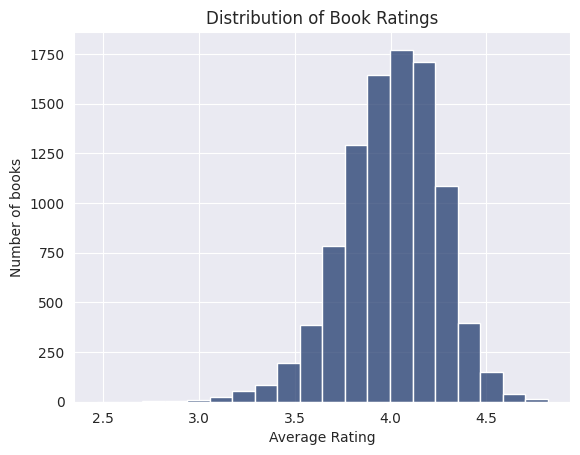

In [8]:
ax = sns.histplot(data=books_df, x="average_rating", bins=20)
ax.set_title("Distribution of Book Ratings")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Number of books")
plt.show()

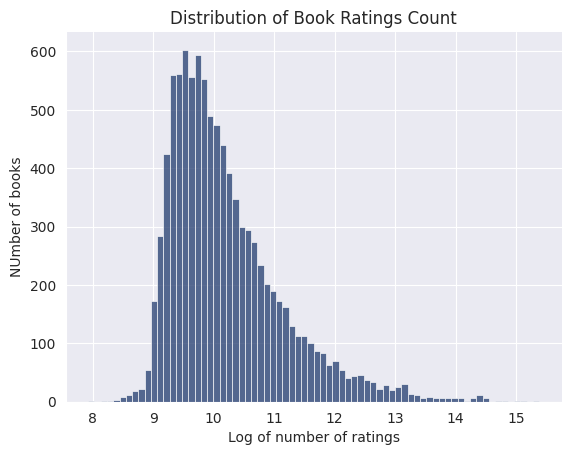

In [9]:
temp_books = pd.DataFrame()
temp_books["ratings_count_log"]=np.log(books_df.ratings_count)
ax = sns.histplot(data = temp_books, x = "ratings_count_log")
ax.set_title("Distribution of Book Ratings Count")
ax.set_xlabel("Log of number of ratings")
ax.set_ylabel("NUmber of books")
sns.despine()
plt.show()

<AxesSubplot:title={'center':'Scatterplot of average book rating vs number of ratings'}, xlabel='ratings_count', ylabel='average_rating'>

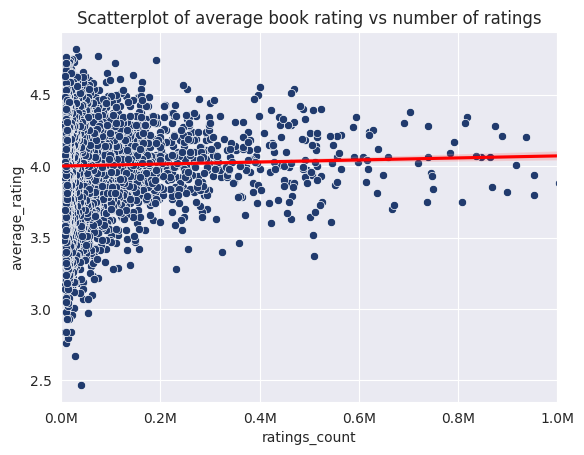

In [10]:
ax = sns.scatterplot(data = books_df, x = "ratings_count", y = "average_rating")
ax.set(xlim=(0, 1000000))
ax.set_title("Scatterplot of average book rating vs number of ratings")
ax.set_xlabel("Number of ratings")
ax.set_ylabel("Rating")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{(x/1000000)}M'))
sns.regplot(data=books_df, x="ratings_count", y="average_rating", scatter=False, color='r')

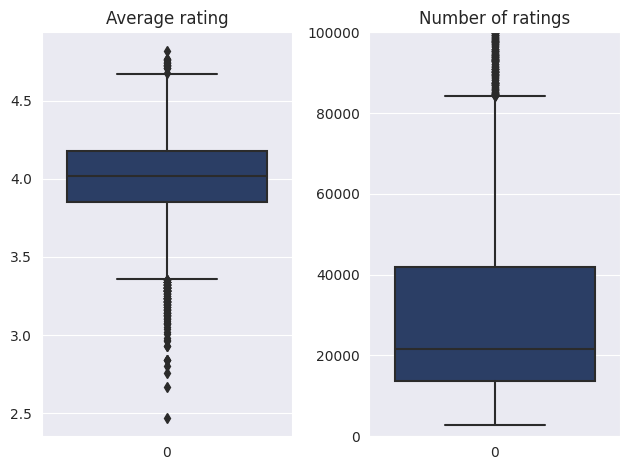

In [11]:
columns_to_plot = ['average_rating', 'ratings_count']
fig, axes = plt.subplots(ncols=len(columns_to_plot))
for column, axis in zip(columns_to_plot, axes):
    if column == 'ratings_count':
        sns.boxplot(data=books_df[column], ax=axis).set(ylim=(0, 100000))
        axis.set_title('Number of ratings')
    else:
        sns.boxplot(data=books_df[column], ax=axis)
        axis.set_title('Average rating')
plt.tight_layout()
plt.show()

## Ratings

In [13]:
ratings_df.head()

,user_id,book_id,rating,date_added
0,8842281e1d1347389f2ab93d60773d4d,16981,3,2016-12-05
1,8842281e1d1347389f2ab93d60773d4d,27161156,0,2016-11-10
2,8842281e1d1347389f2ab93d60773d4d,4866,0,2015-08-19
3,8842281e1d1347389f2ab93d60773d4d,23158207,3,2015-07-29
4,8842281e1d1347389f2ab93d60773d4d,22318578,5,2015-06-07


In [14]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3071801 entries, 0 to 3071800
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     object
 1   book_id     int64 
 2   rating      int64 
 3   date_added  object
dtypes: int64(2), object(2)
memory usage: 93.7+ MB


In [15]:
len(ratings_df["user_id"].unique())

54440

In [16]:
ratings_df[["rating"]].describe()

,rating
count,3.071801e+06
mean,3.800276e+00
std,1.202109e+00
min,0.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [17]:
ratings_df.groupby('user_id')['book_id'].count().head()

user_id
00009e46d18f223a82b22da38586b605    90
0000c3d51aa099745e93a4e99c4856c8    66
000157a6f8331e9c9a21252e1fee91d1    29
000253cf1077f203bca050637f2ec7f7    39
000387b0e3d77b6dcc36a66d5cc27347    34
Name: book_id, dtype: int64

Text(0.5, 1.0, 'Number of ratings by user')

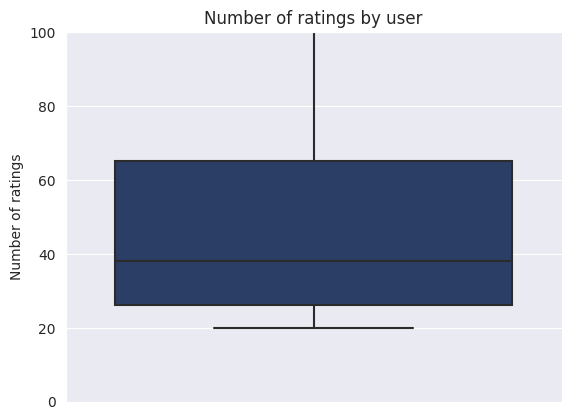

In [18]:
ax = sns.boxplot(y=ratings_df.groupby('user_id')['book_id'].count(), orient="v")
ax.set_ylim(0, 100)
ax.set_ylabel("Number of ratings")
ax.set_title("Number of ratings by user")

## Naive Baseline

In [19]:
import math

mean = train.groupby('book_id').mean()
id_score_dict = mean['rating'].to_dict()

sum = 0
n = 0
for index, row in test.iterrows():
    id = row['book_id']
    if id in id_score_dict:
        sum += (row['rating'] - id_score_dict[id])**2
        n += 1

math.sqrt(sum/n)

1.1846826946244475